# Tutorial BuildME

This tutorial shows the most important functionalities of the BuildME framework using a mix of interactive code cells and text cells. 

The tutorial is divided into two parts. First, we perform a standalone simulation of one building file to present the energy and material simulation tool using a simple example. Second, we create a batch to simulate a combination of buildings with selected characteristics using BuildME aspects, e.g., occupation type, climate, and energy standard. Each part of the tutorial is divided into three sections: setup, simulation, and processing the results. An extra section is added to visualize the batch simulation results. 

## 1. Standalone simulation

### 1.1 Setup

In order for this tutorial to run properly, some initial setup needs to be performed. First, the user needs to install Energy+ software and chosen Python dependencies (eppy, pandas, openpyxl, numpy, tqdm, matplotlib). These steps and other potential setup issues are described in the [setup.md](https://github.com/nheeren/BuildME/blob/master/docs/setup.md) file in the documentation.

Otherwise, BuildME standalone simulation was designed to provide energy and material demand with a minimum amount of extra information from the user. 

### 1.2 Simulation

#### Energy demand simulation

First, we will simulate the energy demand of the building using the calculate_energy() function. The function's inputs include paths to various essential files, and a dictionary called "replace_dict" to specify the values of BuildME "replacement" aspects. Please note that the dictionary is not required for files that are NOT part of the BuildME framework.

Replacement aspects, e.g., energy standard (en-std) and resource efficiency scenario (res), are building characteristics that are subject to replacement changes in BuildME through automatic modification of the idf file. For each such aspect, the algorithm substitutes the default values with customized ones for the chosen aspect value, e.g., energy standard value "efficient". For example, the energy standard aspect specifies the thickness of the insulation layer, the U-value of glazed surfaces, and the air infiltration levels. 

In [1]:
from BuildME import batch, simulate, settings
import os
out_dir = os.path.abspath("./tmp/test/") # output directory where the files will be saved
ep_dir = os.path.abspath("./bin/EnergyPlus-9-2-0/") # path to the EnergyPlus folder
idf_path = os.path.abspath("./data/archetype/USA/SFH.idf") # building file
epw_path = os.path.abspath("./data/climate/USA_NY_New.York-dummy.epw") # weather file
# replace_csv_dir = os.path.abspath("./data/") # a directory of the "replace" csv files - optional for files that use BuildME aspects (in particular: BuildME "replacement" aspects)

In [2]:
simulate.calculate_energy(out_dir=out_dir, idf_path=idf_path, ep_dir=ep_dir, epw_path=epw_path, replace_dict={'en-std': 'standard', 'res': 'RES0'}, clear_folder=False)

Initiating energy demand simulation...
The directory with "replace" csv files not provided or the provided one does not exist. These replace rules will be skipped.
Energy simulation successful in folder 'test'
Energy demand simulation finished.


After around a minute, the energy simulation should be finished. The previously specified output folder is automatically filled with simulation files, typically more than 30, among which the most important are:
- `log_energyplus.txt` with EnergyPlus output log (can be inspected to monitor the simulation progress);
- `eplusout.err` which informs us about critical errors (in case the simulation did not succeed) or warnings;
- `eplusout.csv` which includes variable values, as listed in the *Output:Variable* object of the IDF file;
- `eplusmtr.csv` which includes metered values, as listed in the *Output:Meter* object of the IDF file.

#### Material demand simulation

As a next step, we will simulate the material demand of the building. The function calculate_materials() allows to specify surrogate elements, e.g., basement, that are not part of the idf file but might contribute to the building's material demand. The surrogate elements can be provided in the form of a dictionary (like below) or a pandas dataframe.

IMPORTANT: The code cell below will throw an exception and print out a message "Material demand calculation unsuccessful." 
This is all expected, please just proceed with the tutorial.

In [3]:
simulate.calculate_materials(out_dir=out_dir, idf_path=idf_path,  ep_dir=ep_dir, replace_dict={'en-std': 'standard', 'res': 'RES0'}, clear_folder=False, 
                             ifsurrogates=True, surrogates={'basement':{'height': 0.2, 'materials': 'Concrete_surrogate', 'densities': 2400}})

Initiating material demand simulation...
The directory with "replace" csv files not provided or the provided one does not exist. These replace rules will be skipped.


Exception: The following materials were not found in the atypical materials dictionary: 
 ['Bldg_paper_felt', 'R_high', 'Air_4_in_vert', 'Glass-non-standard', 'Glass-standard', 'Glass-efficient', 'Glass-ZEB', 'int_blind'].
 These materials were added to file "atypical_materials.csv" located in "c:\Users\kamilami\all\buildings\BuildME\tmp\test".
 Material demand calculation unsuccessful.

The material demand was unsuccessful because some materials used in the idf file do not have specified densities and/or thicknesses, which are needed for calculating the material demand. These materials were added to a file "atypical_materials.csv" located in the directory specified as "out_dir".

Please find "atypical_materials.csv", open it, substitute the question marks with values, and save the file. Now, you can execute the same code again and the atypical_materials.csv file will be automatically read. Alternatively, you can also use a parameter "atypical_materials" to provide the information directly to the function calculate_materials() using a dictionary or a pandas dataframe. 

In [4]:
simulate.calculate_materials(out_dir=out_dir, idf_path=idf_path,  ep_dir=ep_dir, replace_dict={'en-std': 'standard', 'res': 'RES0'}, clear_folder=False, 
                             ifsurrogates=True, surrogates={'basement':{'height': 0.2, 'materials': 'Concrete_surrogate', 'densities': 2400}})

Initiating material demand simulation...
The directory with "replace" csv files not provided or the provided one does not exist. These replace rules will be skipped.
Atypical materials automatically read from "atypical_materials.csv" located in "c:\Users\kamilami\all\buildings\BuildME\tmp\test".
Material demand simulation finished.


As you can see, the material demand simulation was finished successfully. The previously specified output folder is automatically filled with the following files:
- `mat_demand.csv` lists the mass of various material types (kg) contained in the entire building;
- `geom_stats.csv` lists the information about building geometry, such as the floor area, the area of external walls, etc.

### 1.3 Processing the results

Simulations are ready! Now, we can summarize the results. First, we aggregate the energy demand and calculate the intensity, i.e., the energy or material demand per square meter of the building. Here, we use 'total_floor_area' (default value), but it is also possible to select 'floor_area_occupied' or 'floor_area_conditioned'. 

In [5]:
simulate.aggregate_energy(folders=[out_dir], unit='kWh')
simulate.calculate_intensities(folders=[out_dir], ref_area='total_floor_area')

Aggregating energy simulation results...
Calculating intensities of the energy and/or material simulation results...


The intensities are automatically saved to .csv files placed in the "out_dir" folder. Below, we read some of the .csv files using pandas dataframes.

In [6]:
import pandas as pd
pd.read_csv(os.path.join(out_dir, 'energy_demand_m2.csv'))

,EnergyPlus output variable,Unit,Value
0,Cooling:EnergyTransfer,kWh/m2,24.164631
1,Heating:EnergyTransfer,kWh/m2,20.153232
2,InteriorEquipment:Electricity,kWh/m2,30.069084
3,InteriorLights:Electricity,kWh/m2,6.570000
4,TOTAL,kWh/m2,80.956947


In [7]:
pd.read_csv(os.path.join(out_dir, 'mat_demand_m2.csv'))

,Material name,Unit,Value
0,F13 Built-up roofing,kg/m2,6.273635
1,Reinforcement_1perc_22cm,kg/m2,10.182864
2,Concrete_22cm,kg/m2,290.931564
3,insulation_layer-16cm,kg/m2,11.396412
4,F08 Metal surface,kg/m2,3.690595
5,Stucco_1in,kg/m2,40.296160
6,Bldg_paper_felt,kg/m2,0.000000
7,sheathing_consol_layer,kg/m2,7.180036
8,Concrete_15cm,kg/m2,445.867278
9,Reinforcement_1perc_15cm,kg/m2,15.605752


The materials listed above can also be aggregated into categories using the function aggregate_materials(). The variable aggregation_categories can be provided directly to the function or can be automatically read from "aggregation_categories.csv". In the second case, the function has to be run twice (similarly to atypical_materials.csv above): first to create the file, and then to perform the calculations (after having entered the required data into the csv file). By default, the materials are classified as '?'.

In [8]:
simulate.aggregate_materials(folders=[out_dir])

Aggregating material simulation results...
The following materials were not found in the material aggregation dictionary: 
 ['Concrete_surrogate', 'Glass-standard', 'F13 Built-up roofing', 'sheathing_consol_layer', 'Carpet_n_pad', 'insulation_layer-12cm', 'OSB_5/8in', 'Bldg_paper_felt', 'Concrete_15cm', 'Concrete_22cm', 'Plywood_3/4in', 'door_const', 'insulation_layer-16cm', 'Stucco_1in', 'Reinforcement_1perc_15cm', 'F08 Metal surface', 'Std Wood 6inch', 'Drywall_1/2in', 'Reinforcement_1perc_22cm']
 These materials were added to file "aggregation_categories.csv" located in "c:\Users\kamilami\all\buildings\BuildME\tmp\test".
 Unless the aggregation category is specified,  these materials will continue to be classified as '?'.


In [9]:
pd.read_csv(os.path.join(out_dir, 'mat_demand_aggregated_m2.csv'))

,Material type,Unit,Value
0,?,kg/m2,1390.654303
1,TOTAL,kg/m2,1390.654303


## 2. Batch simulation

Batch simulations allow BuildME users to easily simulate multiple buildings with a combination of selected characteristics. Batch simulations use BuildME aspects, for example occupation type, climate, or energy standard. This kind of simulation is mostly suited to idf files that are part of the BuildME framework, especially if the aspects to be used require prior idf file modification (aspects "energy standard", "resource efficiency scenario" (res) and "cooling"). However, it is possible to add new files to the framework (see "Adding new archetypes" in [framework.md](https://github.com/nheeren/BuildME/blob/master/docs/framework.md) in the documentation). 

### 2.1 Setup

#### Initial setup

Batch simulations make use of variables and data saved in the files "BuildME/settings.py" and "BuildME_config_V1.0.xlsx" (config file). In principle, the simulation should run without updating these files if EnergyPlus was properly installed and all the other steps described in the [setup.md](https://github.com/nheeren/BuildME/blob/master/docs/setup.md) were followed.

#### Selection of archetypes

Next, we select the combination of buildings we want to simulate. These characteristics are automatically read from the config file's "debug combinations" sheet.

In [10]:
settings.debug_combinations

{'USA': {'occupation': ['SFH'],
  'en-std': ['non-standard', 'standard', 'efficient', 'ZEB'],
  'res': ['RES0'],
  'climate_region': ['4A'],
  'climate_scenario': ['2015'],
  'cooling': ['HVAC']}}

The selected building is a single family house (**SFH**) located in the **US**. We assume that the building is built without extra requirements on resource efficiency (**RES0**) and that the cooling demand is fulfilled solely using the **HVAC** system. We choose mixed humid climate such as in Baltimore (climate region **4A**) in the reference year **2015**. We are interested in how the energy standard influences the energy use in the building, so we select four different ones: **standard**, **non-standard** (below standard), **efficient** and **ZEB**.

The BuildME archetype files can be found in folder "BuildME\data\archetype\USA\". The weather files need to be created by the user using dedicated software, e.g. Meteonorm, and can be found in folder "BuildME\data\climate\meteonorm71\**reference year**\". The names of the weather file for each climate are specified in the "climate_stations" variable in "settings.py". 

If the specific weather file is not found, BuildME uses a dummy weather file for New York, NY (climate region 4A), [made available by the U.S. Department of Energy](https://www.energycodes.gov/prototype-building-models).

#### Initiating a batch simulation


Based on the chosen archetype combinations, a batch simulation can be initiated. We use the function "create_batch_simulation()" to create a batch, i.e., to structure the information about building instances to be simulated, e.g., the location of the .EPW climate file or the IDF building file. 

As part of the function "create_batch_simulation()", a folder "./tmp/timestamp/" is created, where timestamp is a unique identifier of this model run based on the current date and time. Under this folder, subfolders are created, one for each combination from "settings.debug_combinations".

In [11]:
batch_simulation, timestamp = batch.create_batch_simulation(settings.debug_combinations)

Creating batch simulation


### 2.2 Simulation

The simulation is initiated through the functions "simulate.calculate_energy()" and "simulate.calculate_material()", which only need the "batch_simulation" variable to correctly proceed with the calculations. The energy calculation has an optional "parallel" option which activates parallel computing. This can reduce the computational time for large batches of buildings, particularly when combined with a high-performance computing cluster. 

Please note that the energy simulation takes some time to execute, depending on the processing power of your machine. Depending on the chosen archetype and cooling strategy, it can take between around 20 seconds (e.g., for SFH archetype with HVAC cooling) and more than 15 minutes (e.g., MFH archetype with MMV cooling). After the simulation is done, a prinout message appears below, indicating the number of seconds it took to simulate one building (= one iteration) e.g., 22.26s/it.

In [12]:
simulate.calculate_energy(batch_simulation, parallel=True)
simulate.calculate_materials(batch_simulation)

Initiating energy demand simulation...
Perform energy simulation on 7 CPUs...


 75%|███████▌  | 3/4 [02:05<00:41, 41.69s/sim]


Energy demand simulation finished.
Initiating material demand simulation...


100%|██████████| 4/4 [00:02<00:00,  1.36it/s]

Material demand simulation finished.


### 2.3 Processing the results

The results of a batch simulation can be processed with the use of multiple functions. Besides the functions listed for a standalone simulation, there are three extra ones:
- "collect_results()": for every previously created *\*.csv* file, the function summarizes all the building instances and saves the summary under *summary_\*.csv* in the main simulation folder (*.\tmp\timestamp\\*).
- "weighing_climate_region()": weighs the results of the energy simulation according to climate regions. Only useful if all climate types of a given region are simulated (e.g., 5 climate regions in China or 16 climate regions in USA).
- "simulate.cleanup()": allows to clean up the simulation folders by deleting the temporary files (everything in the subfolders), archiving them into a .zip file, or both. 

The last two functions are commented out below, as they are not necessary in our example. 

In [13]:
simulate.aggregate_energy(batch_simulation, unit='kWh')
simulate.aggregate_materials(batch_simulation)
simulate.calculate_intensities(batch_simulation)
simulate.collect_results(batch_simulation)
# simulate.weighing_climate_region(batch_simulation)
# simulate.cleanup(batch_simulation, archive=False, del_temp=True)

Aggregating energy simulation results...
Aggregating material simulation results...
Calculating intensities of the energy and/or material simulation results...


After the summary of the results has been created, it can be displayed in form of a table, as seen below.

In [14]:
pd.read_csv('.//tmp//'+timestamp+'//summary_energy_demand_m2.csv')

,region,occupation,en-std,res,climate_region,climate_scenario,cooling,Building name,EnergyPlus output variable,Unit,Value
0,USA,SFH,non-standard,RES0,4A,2015,HVAC,USA_SFH_non-standard_RES0_4A_2015_HVAC,Cooling:EnergyTransfer,kWh/m2,22.457905
1,USA,SFH,non-standard,RES0,4A,2015,HVAC,USA_SFH_non-standard_RES0_4A_2015_HVAC,Heating:EnergyTransfer,kWh/m2,53.512243
2,USA,SFH,non-standard,RES0,4A,2015,HVAC,USA_SFH_non-standard_RES0_4A_2015_HVAC,InteriorEquipment:Electricity,kWh/m2,30.069084
3,USA,SFH,non-standard,RES0,4A,2015,HVAC,USA_SFH_non-standard_RES0_4A_2015_HVAC,InteriorLights:Electricity,kWh/m2,6.570000
4,USA,SFH,non-standard,RES0,4A,2015,HVAC,USA_SFH_non-standard_RES0_4A_2015_HVAC,TOTAL,kWh/m2,112.609232
5,USA,SFH,standard,RES0,4A,2015,HVAC,USA_SFH_standard_RES0_4A_2015_HVAC,Cooling:EnergyTransfer,kWh/m2,26.252296
6,USA,SFH,standard,RES0,4A,2015,HVAC,USA_SFH_standard_RES0_4A_2015_HVAC,Heating:EnergyTransfer,kWh/m2,18.891682
7,USA,SFH,standard,RES0,4A,2015,HVAC,USA_SFH_standard_RES0_4A_2015_HVAC,InteriorEquipment:Electricity,kWh/m2,30.069084
8,USA,SFH,standard,RES0,4A,2015,HVAC,USA_SFH_standard_RES0_4A_2015_HVAC,InteriorLights:Electricity,kWh/m2,6.570000
9,USA,SFH,standard,RES0,4A,2015,HVAC,USA_SFH_standard_RES0_4A_2015_HVAC,TOTAL,kWh/m2,81.783062


In [15]:
pd.read_csv('.//tmp//'+timestamp+'//summary_mat_demand_aggregated_m2.csv')

,region,occupation,en-std,res,climate_region,climate_scenario,cooling,Building name,Material type,Unit,Value
0,USA,SFH,non-standard,RES0,4A,2015,HVAC,USA_SFH_non-standard_RES0_4A_2015_HVAC,cement,kg/m2,40.296160
1,USA,SFH,non-standard,RES0,4A,2015,HVAC,USA_SFH_non-standard_RES0_4A_2015_HVAC,concrete,kg/m2,1628.053641
2,USA,SFH,non-standard,RES0,4A,2015,HVAC,USA_SFH_non-standard_RES0_4A_2015_HVAC,construction grade steel,kg/m2,68.842206
3,USA,SFH,non-standard,RES0,4A,2015,HVAC,USA_SFH_non-standard_RES0_4A_2015_HVAC,glass,kg/m2,2.974692
4,USA,SFH,non-standard,RES0,4A,2015,HVAC,USA_SFH_non-standard_RES0_4A_2015_HVAC,insulation material,kg/m2,25.686330
5,USA,SFH,non-standard,RES0,4A,2015,HVAC,USA_SFH_non-standard_RES0_4A_2015_HVAC,other,kg/m2,4.504335
6,USA,SFH,non-standard,RES0,4A,2015,HVAC,USA_SFH_non-standard_RES0_4A_2015_HVAC,paper and cardboard,kg/m2,0.061693
7,USA,SFH,non-standard,RES0,4A,2015,HVAC,USA_SFH_non-standard_RES0_4A_2015_HVAC,wood and wood products,kg/m2,42.078794
8,USA,SFH,non-standard,RES0,4A,2015,HVAC,USA_SFH_non-standard_RES0_4A_2015_HVAC,TOTAL,kg/m2,1812.497851
9,USA,SFH,standard,RES0,4A,2015,HVAC,USA_SFH_standard_RES0_4A_2015_HVAC,cement,kg/m2,40.296160


### 2.4 Visualizing the results

Below, we present a visualization of the simulation results. 

In [16]:
df_ene = pd.read_csv('.//tmp//'+timestamp+'//summary_energy_demand_m2.csv')  # , index_col=[0, 1, 2, 3, 4, 5, 6])
df_mat = pd.read_csv('.//tmp//'+timestamp+'//summary_mat_demand_aggregated_m2.csv')  # , index_col=[0, 1, 2, 3, 4, 5, 6])
energy_unit = df_ene['Unit'][0]
material_unit = df_mat['Unit'][0]
df_ene = df_ene.drop(columns=['region', 'occupation', 'res', 'climate_region', 'climate_scenario', 'cooling', 'Building name', 'Unit']) # keep 'en-std'
df_mat = df_mat.drop(columns=['region', 'occupation', 'res', 'climate_region', 'climate_scenario', 'cooling', 'Building name', 'Unit']) # keep 'en-std'
df_ene = df_ene[df_ene['EnergyPlus output variable'] != 'TOTAL']
df_ene['en-std'] = df_ene['en-std'].astype("category")
df_ene['en-std'] = df_ene['en-std'].cat.set_categories(['non-standard', 'standard', 'efficient', 'ZEB'])
df_mat['en-std'] = df_mat['en-std'].astype("category")
df_mat['en-std'] = df_mat['en-std'].cat.set_categories(['non-standard', 'standard', 'efficient', 'ZEB'])
df_mat = df_mat[df_mat['Material type'] != 'TOTAL']
df_ene = df_ene.set_index(['en-std', 'EnergyPlus output variable'])
df_mat = df_mat.set_index(['en-std', 'Material type'])
df_ene = df_ene.unstack(level=-1)
df_mat = df_mat.unstack(level=-1)

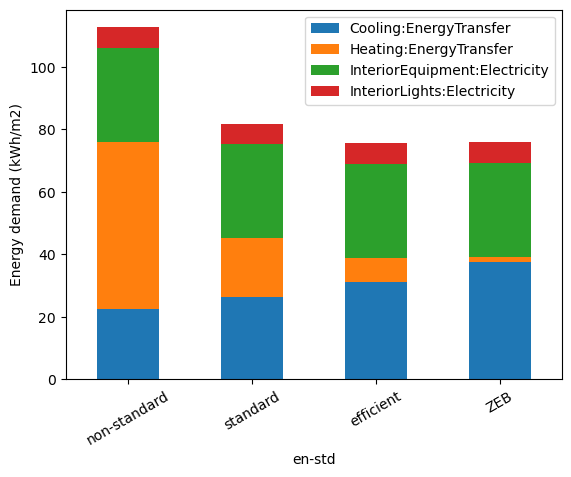

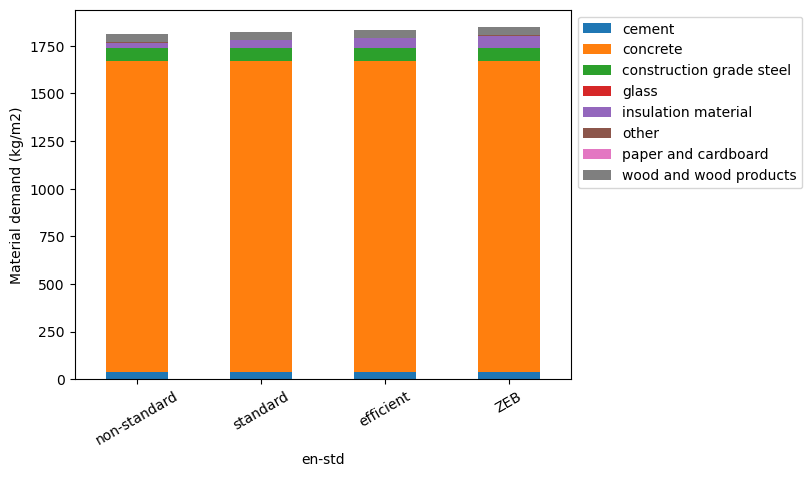

In [17]:
import matplotlib.pyplot as plt
(df_ene['Value']).plot.bar(rot=30, stacked=True, label=df_mat.index)
plt.ylabel(f"Energy demand ({energy_unit})")
plt.legend(bbox_to_anchor=(1,1))  
plt.show()
(df_mat['Value']).plot.bar(rot=30, stacked=True, label=df_mat.index)
plt.ylabel(f"Material demand ({material_unit})")
plt.legend(bbox_to_anchor=(1,1))  
plt.show()

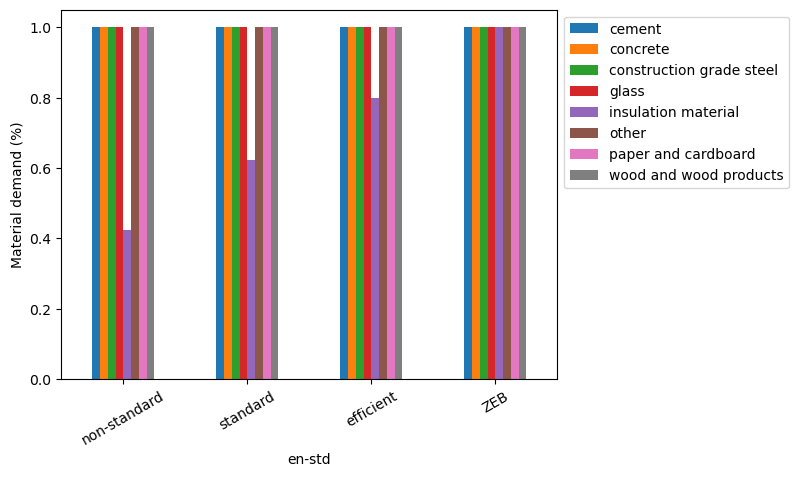

In [18]:
(df_mat['Value']/df_mat['Value'].max()).plot.bar(rot=30, stacked=False, label=df_mat.index)
plt.ylabel(f"Material demand (%)")
plt.legend(bbox_to_anchor=(1,1))  
plt.show()